# End-to-end Test

### Pulkit Mathur, Vaibhav Saxena, Sumeet Ranka, Duc Thong

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys
import random
import time
import scipy  
import pickle
from keras.optimizers import Adam
import end_to_end_network as etem
from skimage.measure import compare_ssim, compare_psnr
from tqdm import tqdm

### Testing model on FastMRI data

In [4]:
import cv2 as cv
from scipy import ndimage
import copy

def mse(gt, pred):
    """ Compute Mean Squared Error (MSE) """
    return np.mean((gt - pred) ** 2)

def nmse(gt, pred):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2


def psnr(gt, pred):
    """ Compute Peak Signal to Noise Ratio metric (PSNR) """
    return compare_psnr(gt, pred, data_range=gt.max())


def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt, pred, multichannel=False, data_range=gt.max()
    )

def calculatemetric(imageA, imageB):
    return np.array([nmse(imageA, imageB),ssim(imageA, imageB),psnr(imageA, imageB)])

def compare_images(imageA, imageB, imageC, normalize=False):
    
    nimageB = copy.deepcopy(imageB)
    if normalize:
        cv.normalize(imageB,  nimageB, 0, 255, cv.NORM_MINMAX)
    
    mb = nmse(imageA, nimageB)
    sb = ssim(imageA, nimageB)
    pb = psnr(imageA, nimageB)
    mc = nmse(imageA, imageC)
    sc = ssim(imageA, imageC)
    pc = psnr(imageA, imageC)
    
    imageA = ndimage.rotate(imageA, -90)
    imageB = ndimage.rotate(imageB, -90)
    imageC = ndimage.rotate(imageC, -90)
    
    fig = plt.figure(figsize=(10,10))
    plt.suptitle("Target vs network MSE: %.5f, SSIM: %.2f, PSNR: %.2f" % (mb, sb, pb)+" Target vs Zeroimputed MSE: %.5f, SSIM: %.2f, PSNR: %.2f" % (mc, sc, pc))
     
    ax = fig.add_subplot(2, 2, 1)
    plt.imshow(imageA, cmap="gray")
    plt.axis("off")

    ax = fig.add_subplot(2, 2, 2)
    plt.imshow(imageB, cmap="gray")
    plt.axis("off")
    
    ax = fig.add_subplot(2, 2, 3)
    plt.imshow(imageA, cmap="gray")
    plt.axis("off")

    ax = fig.add_subplot(2, 2, 4)
    plt.imshow(imageC, cmap="gray")
    plt.axis("off")  
    plt.show()
    
def standardize(maskedkspace):
    output = copy.deepcopy(maskedkspace)
    temp = np.array(maskedkspace[:,:,:,0]) +1j*np.array(maskedkspace[:,:,:,1])
    mean = temp.mean()
    std = temp.std()
    temp = (temp-mean)/std
    output[:,:,:,0] = temp.real
    output[:,:,:,1] = temp.imag
    return output

def imagetokspace(image):
    s = image.shape
    kspace = np.zeros((s[0],s[1],2))
    temp = np.fft.fft2(image[:,:,0])
    kspace[:,:,0] = temp.real
    kspace[:,:,1] = temp.imag
    return kspace

### Loading Testing Data

In [5]:
#Testing data
with (open('Xtest.pickle', "rb")) as openfile:
    mi_test = np.abs(pickle.load(openfile))

In [6]:
#Testing data
with (open('Xtest.pickle', "rb")) as openfile:
    mi_test = np.abs(pickle.load(openfile))
    
mk_test = np.zeros((mi_test.shape[0],320,320,2))

for i in range(mi_test.shape[0]):
    mk_test[i,:,:,:] = imagetokspace(mi_test[i])

In [7]:
import pickle
import numpy as np
with (open('Ytest.pickle', "rb")) as openfile:
    oi_test = np.abs(pickle.load(openfile))

In [8]:
print("Total number of data points in test dataset:",mk_test.shape[0])

Total number of data points in test dataset: 7101


#### Results for image constructed from zero imputed/undersampled k-space

In [25]:
#Average NMSE, SSIM and PSNR across testing data
results = np.array([0.0,0.0,0.0])
for i in tqdm(range(oi_test.shape[0])):
    results += calculatemetric(oi_test[i,:,:,0],mi_test[i,:,:,0])
results/oi_test.shape[0]

  0%|          | 0/7101 [00:00<?, ?it/s]/home/dchtruong/anaconda3/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
100%|██████████| 7101/7101 [00:55<00:00, 127.98it/s]


array([ 0.05115421,  0.38867954, 19.24448692])

##### Testing end to end model having k-space MSE and image MSE

In [31]:
import os
stats = np.load("training_data_stats20.npy")

model = etem.etem(stats[0],stats[1],stats[2],stats[3],kshape = (5,5),kshape2=(3,3))

opt = Adam()
model.compile(loss = [etem.nrmse,etem.nrmse],optimizer=opt, loss_weights=[0.02, 0.98])

model_name = "end_to_end_MSE.hdf5"
if os.path.isfile(model_name):
    print("loading weights")
    model.load_weights(model_name)

loading weights


In [32]:
pred = np.zeros((mk_test.shape[0],320,320,1))
for i in tqdm(range(789)):
    index = i*9
    pred[index:index+9,:,:,:] = model.predict(mk_test[index:index+9,:,:,:])[1].astype(np.float64)

100%|██████████| 789/789 [03:26<00:00,  3.83it/s]


In [33]:
#Average NMSE, SSIM and PSNR across testing data
results = np.array([0.0,0.0,0.0])
for i in tqdm(range(oi_test.shape[0])):
    results += calculatemetric(oi_test[i,:,:,0],pred[i,:,:,0])
results/oi_test.shape[0]

  0%|          | 0/7101 [00:00<?, ?it/s]/home/dchtruong/anaconda3/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
100%|██████████| 7101/7101 [01:33<00:00, 75.69it/s]


array([ 0.03896339,  0.39813527, 19.64997836])

##### Looking at some of the results

/home/dchtruong/anaconda3/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


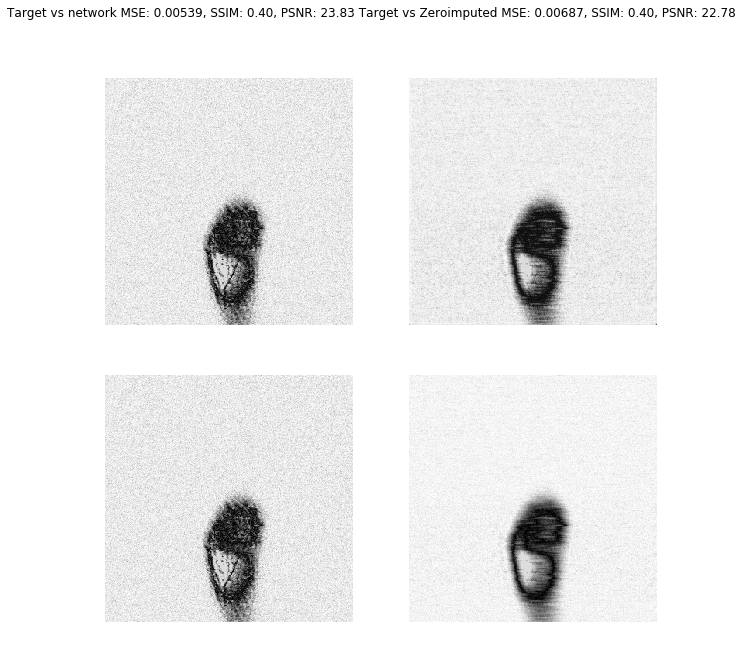

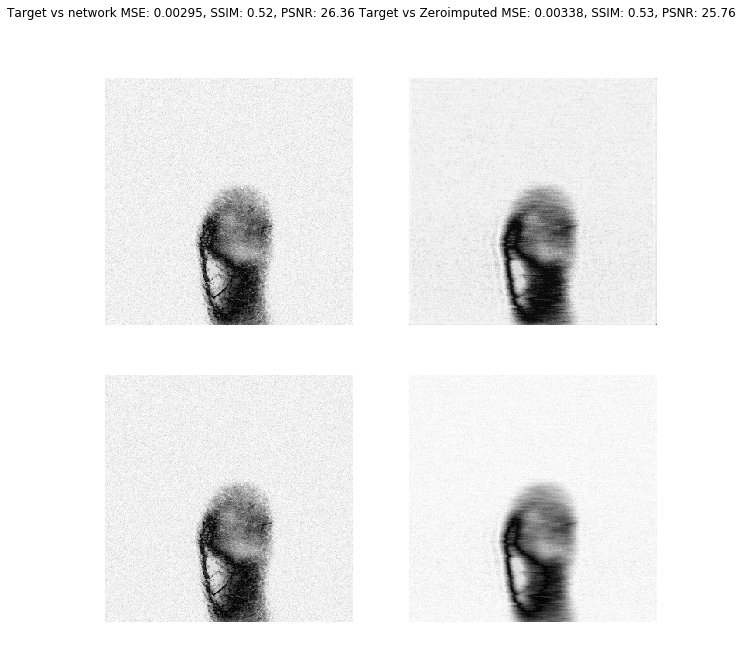

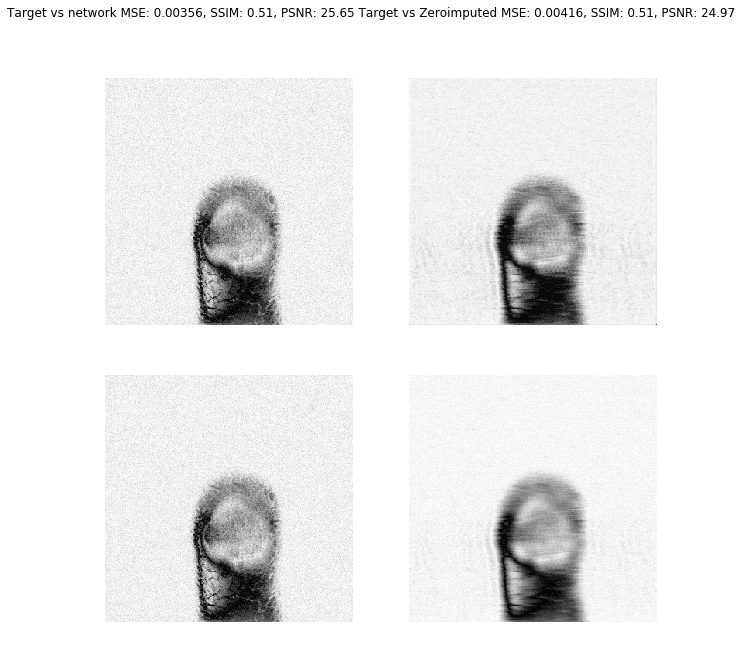

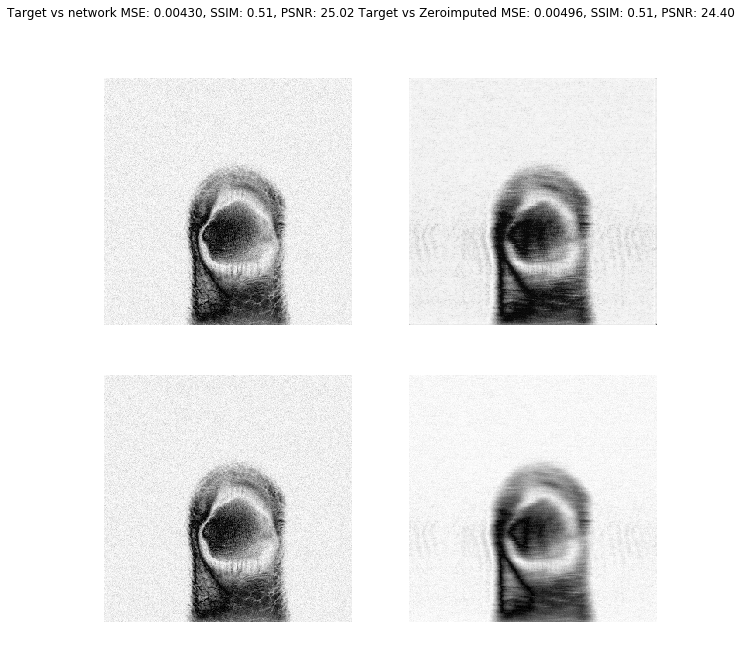

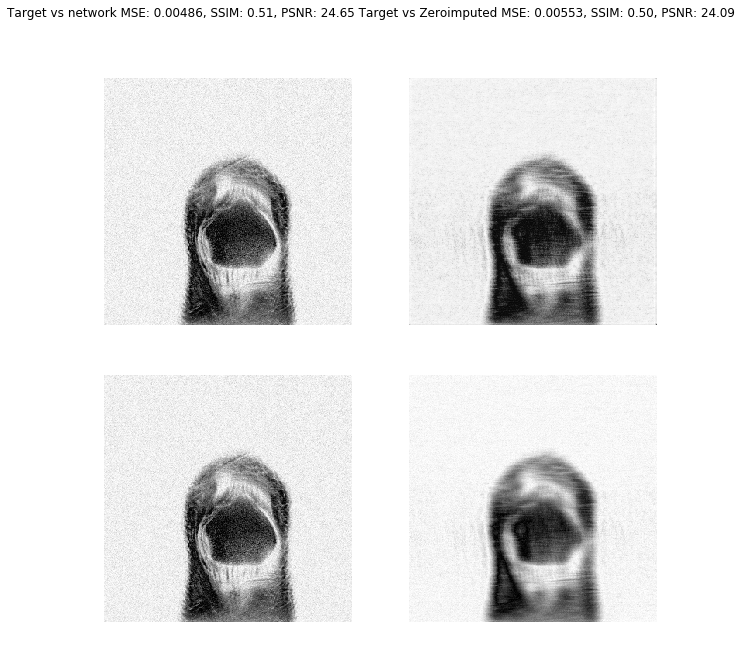

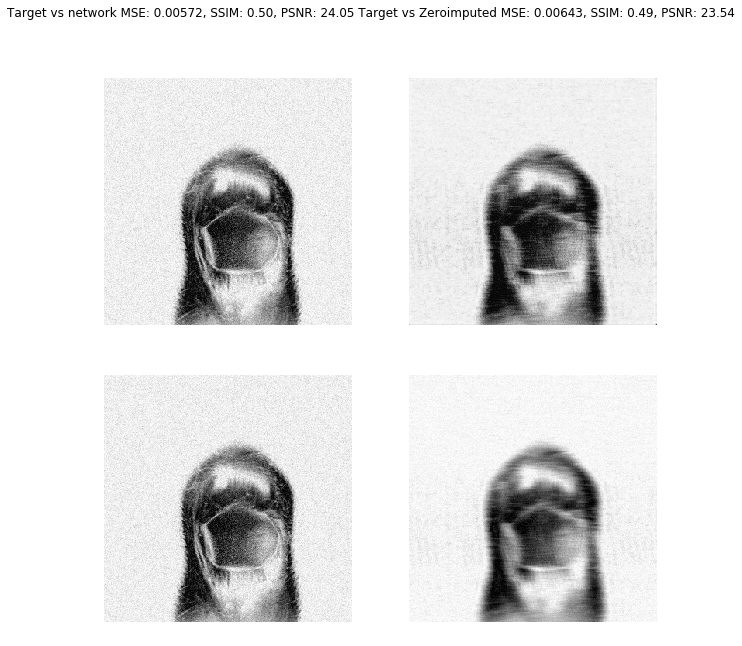

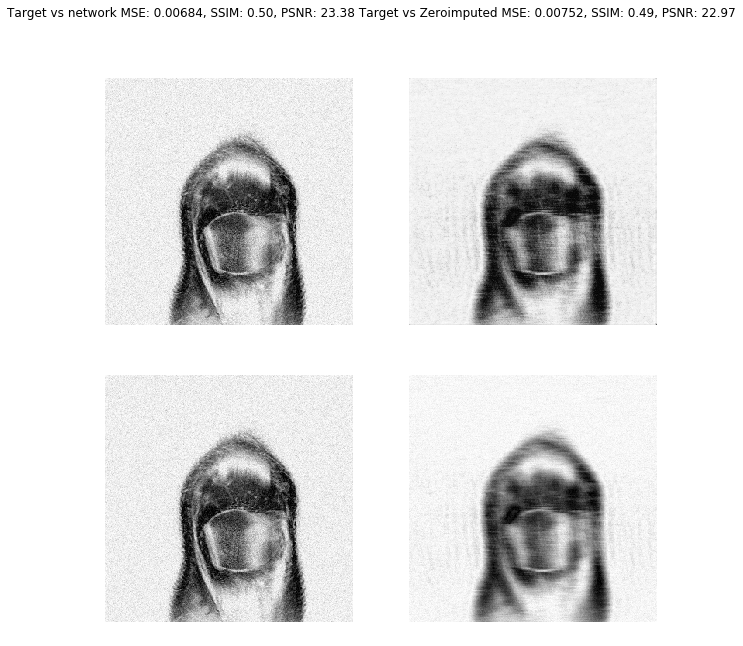

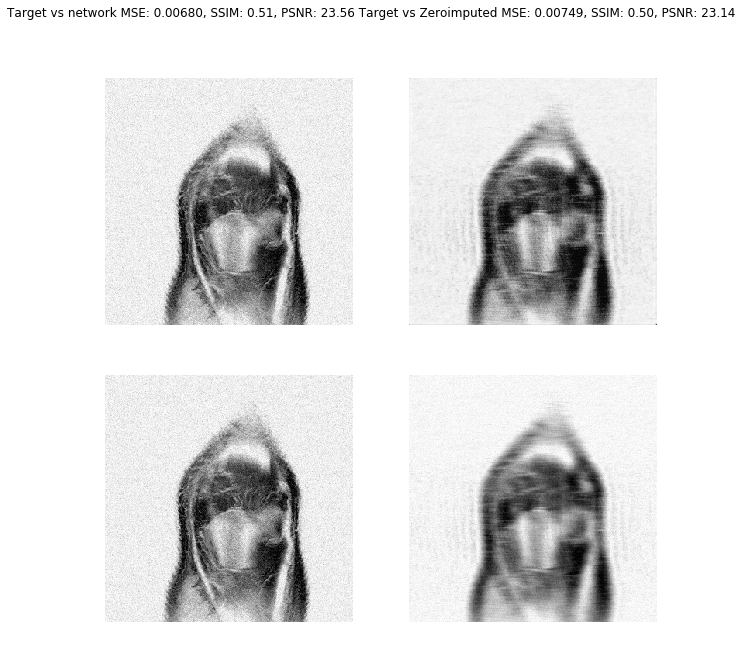

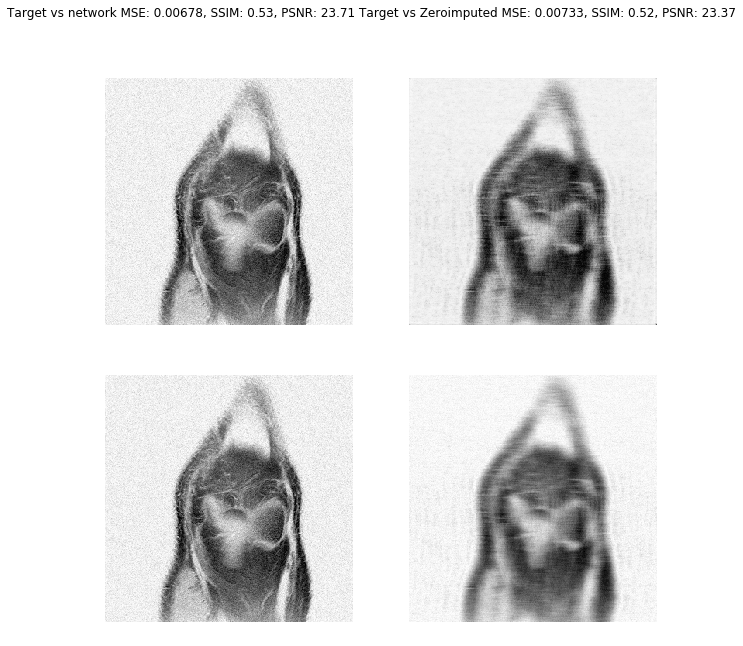

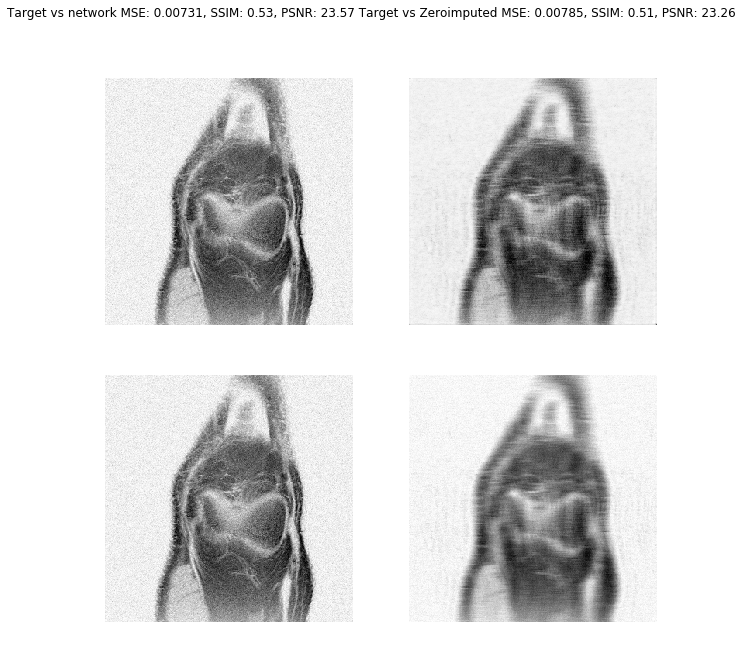

In [35]:
for i in range(10):
    compare_images(oi_test[i,:,:,0],pred[i,:,:,0],mi_test[i,:,:,0])

##### Testing end to end model having k-space MSE, image MSE and image SSIM loss

In [21]:
import os
stats = np.load("training_data_stats20.npy")

model = etem.ete(stats[0],stats[1],stats[2],stats[3],kshape = (5,5),kshape2=(3,3))

opt = Adam()
model.compile(loss = [etem.nrmse,etem.nrmse,etem.ssimloss],optimizer=opt, loss_weights=[0.02, 0.80, 0.18])

model_name = "end_to_end_MSE_SSIM.hdf5"
if os.path.isfile(model_name):
    print("loading weights")
    model.load_weights(model_name)

loading weights


In [22]:
pred = np.zeros((mk_test.shape[0],320,320,1))
for i in tqdm(range(789)):
    index = i*9
    pred[index:index+9,:,:,:] = model.predict(mk_test[index:index+9,:,:,:])[1].astype(np.float64)

100%|██████████| 789/789 [03:25<00:00,  3.86it/s]


In [24]:
#Average NMSE, SSIM and PSNR across testing data
results = np.array([0.0,0.0,0.0])
for i in tqdm(range(oi_test.shape[0])):
    results += calculatemetric(oi_test[i,:,:,0],pred[i,:,:,0])
results/oi_test.shape[0]

  0%|          | 0/7101 [00:00<?, ?it/s]/home/dchtruong/anaconda3/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
100%|██████████| 7101/7101 [01:18<00:00, 90.16it/s]


array([ 0.03353767,  0.4400798 , 19.94765665])

##### Looking at some of the results

/home/dchtruong/anaconda3/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


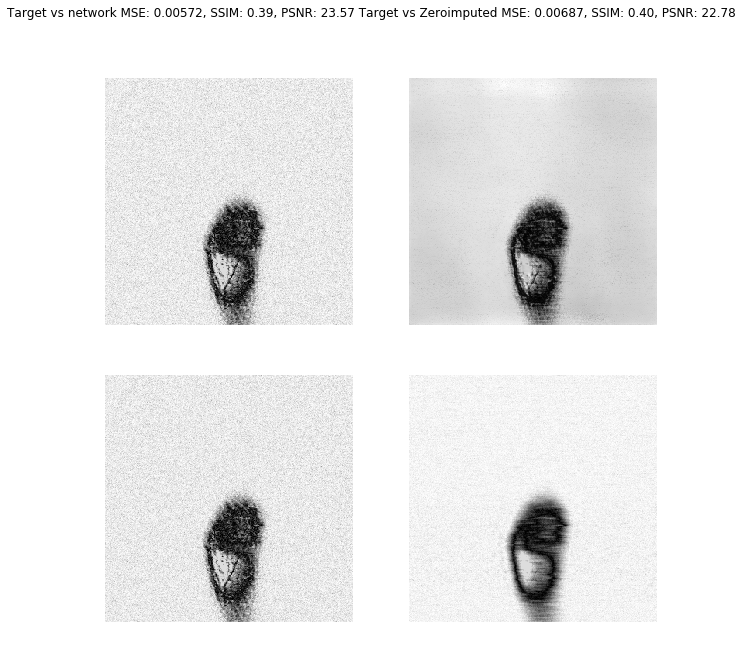

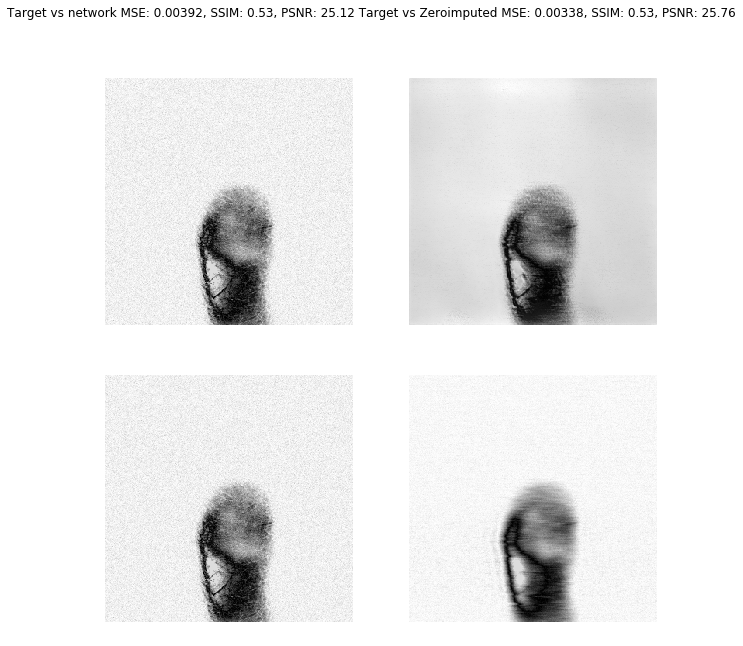

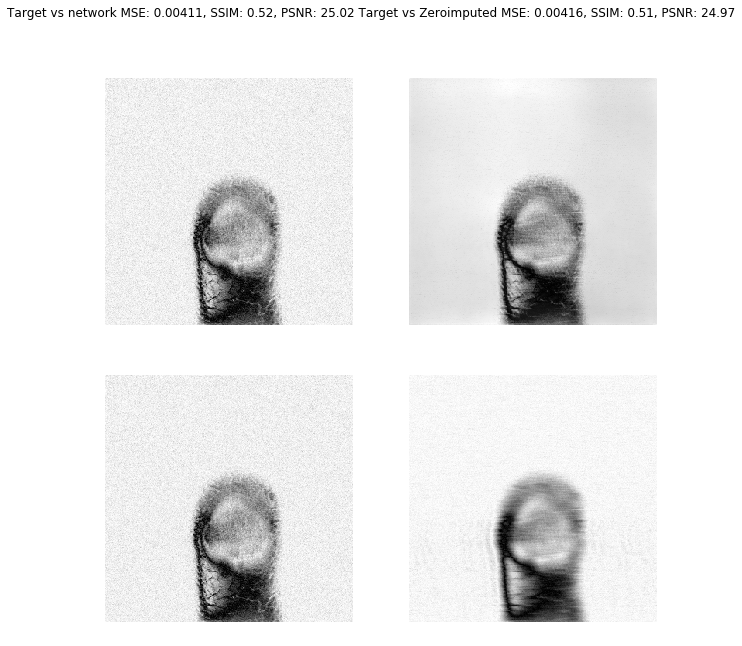

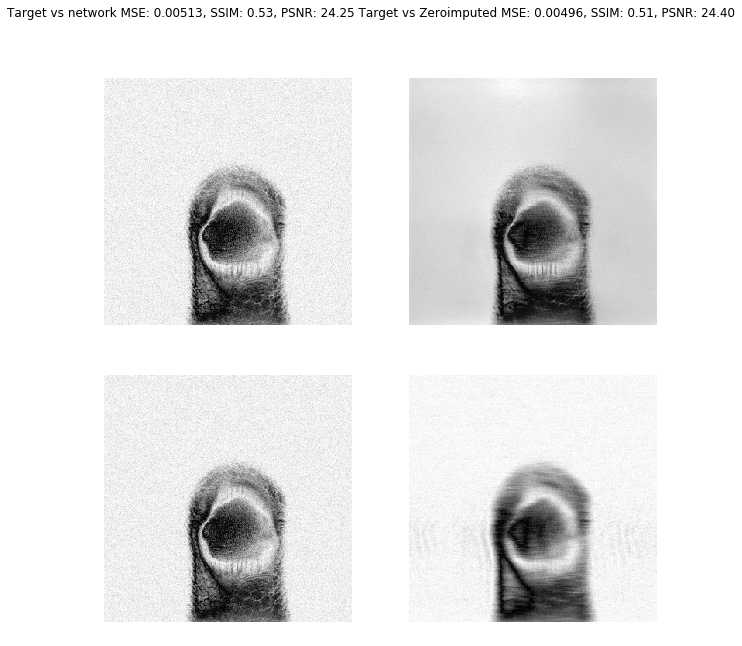

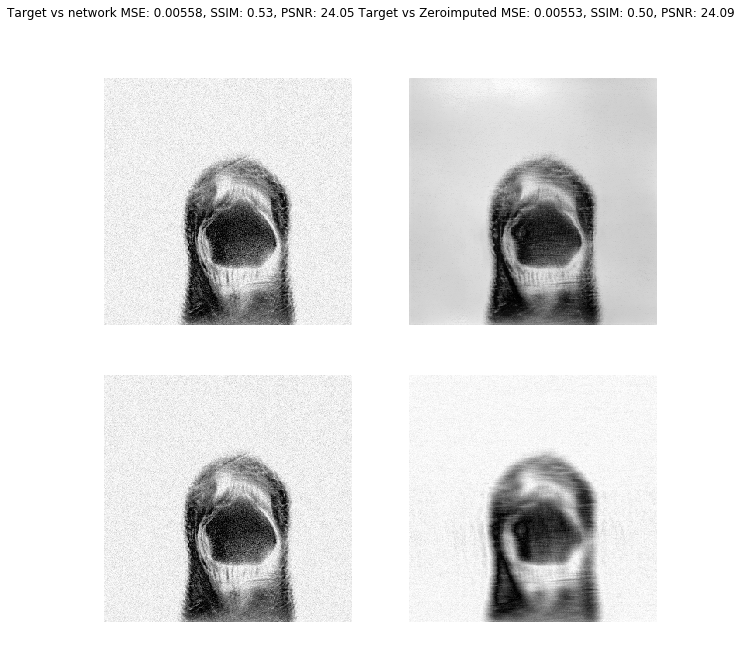

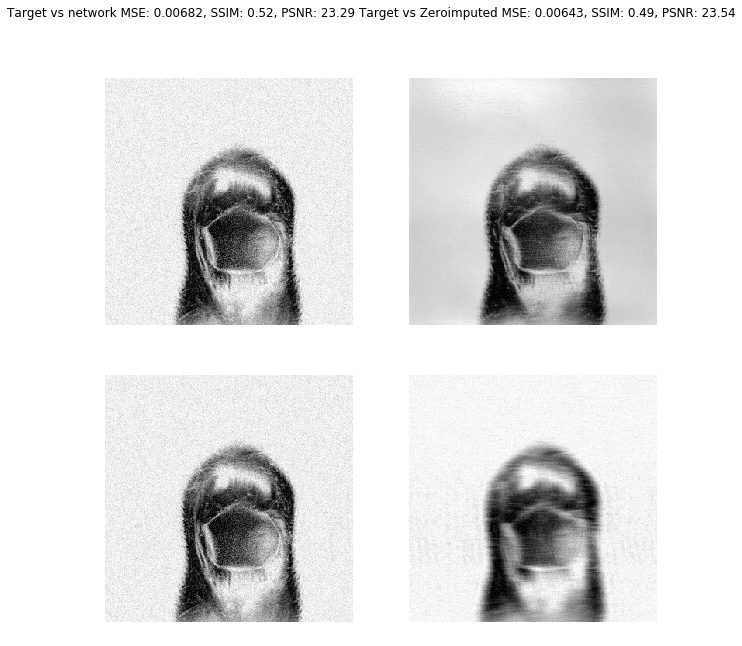

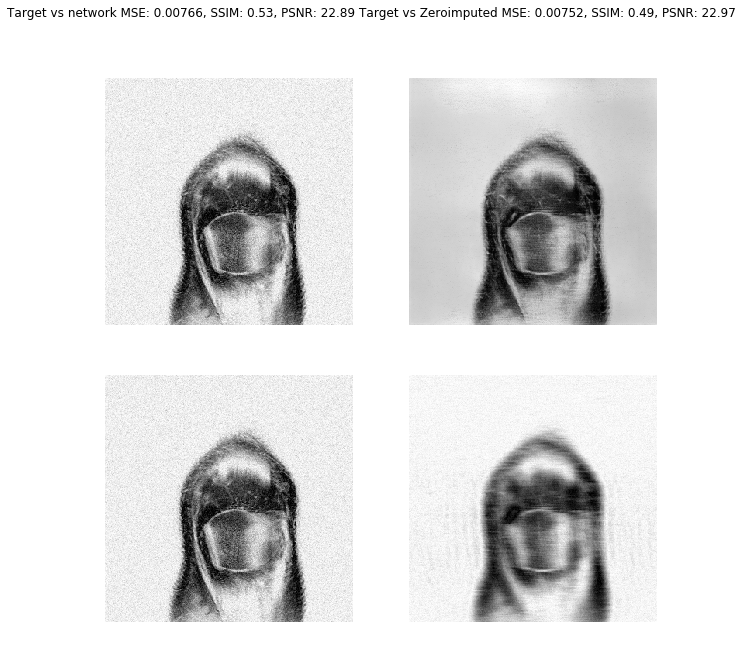

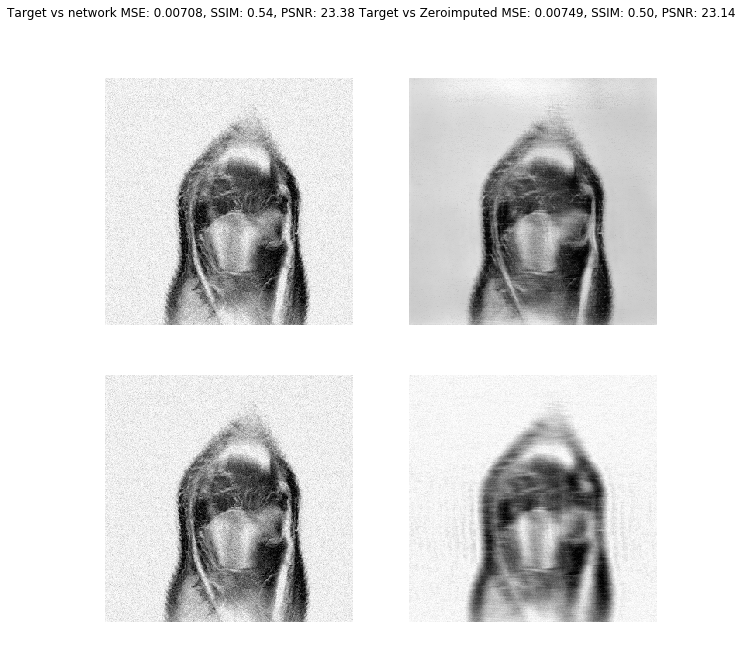

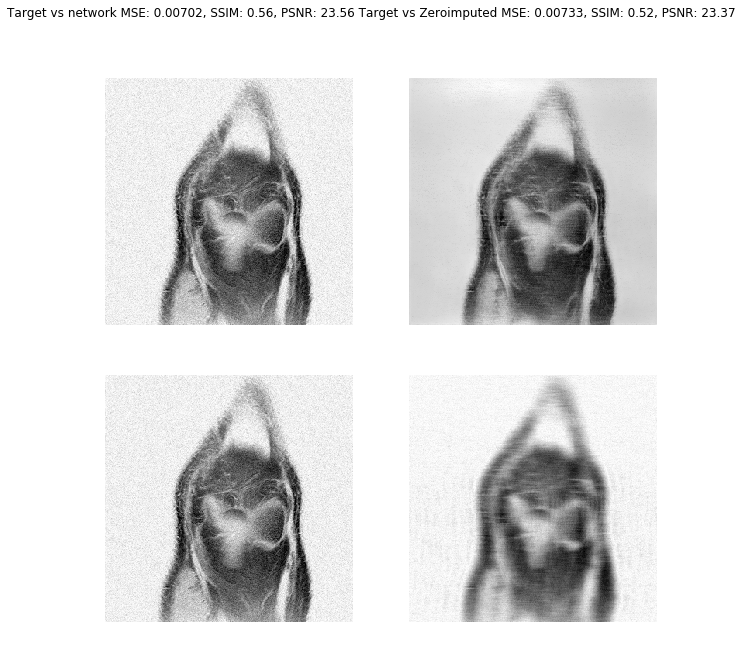

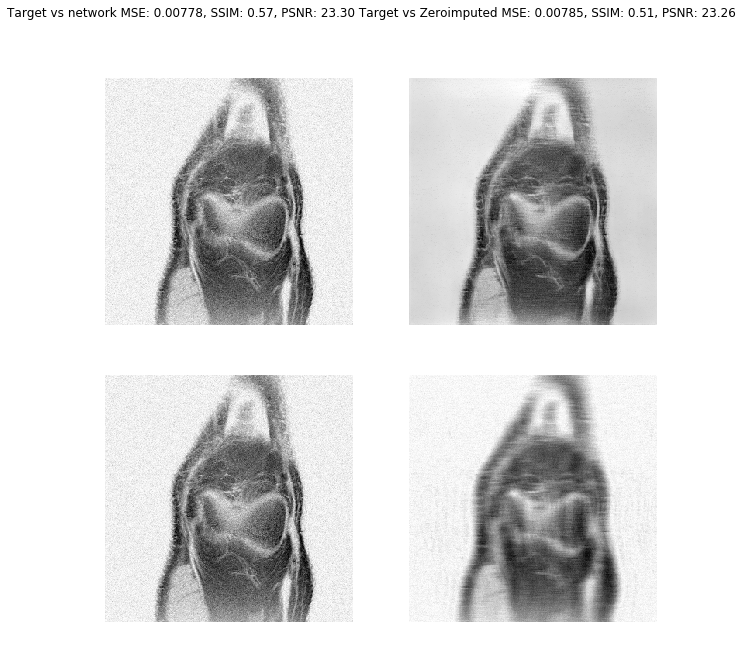

In [23]:
for i in range(10):
    compare_images(oi_test[i,:,:,0],pred[i,:,:,0],mi_test[i,:,:,0])